In [31]:
import mne
from mne.io import read_raw_eeglab
from eegip.preprocessing import preprocess, mark_bad_channels, add_bad_segment_annot, remove_rejected_ica_components
import numpy as np
import matplotlib.pylab as plt
import matlab.engine
from pathlib import Path

In [ ]:
subject = '602'
path = '/media/christian/seagate/eegip/london/derivatives/lossless/'
path = path + 'sub-s{subject}/ses-m06/eeg/sub-s{subject}_ses-m06_eeg_qcr.set'.format(subject=subject)

### Computing ERP in EEGLAB and Fieldtrip using the MATLAB engine

In [55]:
matlab_script = """
%% EEGLAB
subject = '{subject}';

file = '{path}';

EEG = pop_loadset('filename', file);
EEG = eeg_checkset(EEG);
%purge all channels, time, and components that were flagged...
EEG = pop_marks_select_data(EEG, 'channel marks',[],'labels',{{'manual', 'rank'}}, 'remove','on');
EEG = pop_marks_select_data(EEG, 'time marks', [], 'labels', {{'manual'}}, 'remove', 'on');
EEG = pop_marks_select_data(EEG, 'component marks', [], 'labels', {{'manual'}}, 'remove', 'on');

filename = ['sub-s' subject '_ses-m06_eeg_cleaned.set'];
pop_saveset(EEG, 'filename', filename);

eeglab_epochs = pop_epoch(EEG, {{'noisO'}}, [-0.2, 1.0]);

%% Fieldtrip
cfg                         = [];
cfg.dataset                 = filename;
cfg.trialfun                = 'ft_trialfun_general'; % this is the default
cfg.trialdef.eventtype      = 'trigger';
cfg.trialdef.prestim        = 0.2; % in seconds
cfg.trialdef.poststim       = 1.0; % in seconds

cfg.trialdef.eventvalue     = {{'noisO'}};
cfg_noise = ft_definetrial(cfg);

cfg_noise.demean          = 'no';
cfg_noise.lpfilter        = 'no'; 
%cfg_noise.demean          = 'yes';
%cfg_noise.baselinewindow  = [-1.0 0];
%cfg_noise.lpfilter        = 'yes'; 
%cfg_noise.lpfreq          = 45.0;
data_noise = ft_preprocessing(cfg_noise);

selchan = ft_channelselection({{'all'}}, data_noise.label);
cfg = [];
cfg.channel = selchan;

data_noise = ft_selectdata(cfg, data_noise);

cfg = [];
cfg.covariance = 'yes';
cfg.covariancewindow = [-inf 0]; %it will calculate the covariance matrix
                               % on the timepoints that are
                               % before the zero-time point in the trials
cfg.keeptrials = 'yes';

tlck_noise = ft_timelockanalysis(cfg, data_noise);


fieldtrip_size = size(tlck_noise.trial);
eeglab_size = size(eeglab_epochs.data, [3, 1, 2]);

fieldtrip_ts = squeeze(mean(tlck_noise.trial, [1, 2]));
eeglab_ts = mean(eeglab_epochs.data, [1, 3]);
"""

matlab_script = matlab_script.format(subject=subject, path=path)

with open("test_erp_eeglab_fieldtrip.m","w+") as f:
    f.write(matlab_script)

eng = matlab.engine.start_matlab()
eng.test_erp_eeglab_fieldtrip(nargout=0)

In [58]:
fieldtrip_ts = np.squeeze(np.array(eng.workspace['fieldtrip_ts']))
eeglab_ts = np.squeeze(np.array(eng.workspace['eeglab_ts']))

fieldtrip_size = np.squeeze(np.array(eng.workspace['fieldtrip_size'])).astype(int)
eeglab_size = np.squeeze(np.array(eng.workspace['eeglab_size'])).astype(int)

### Computing ERP in MNE using the MATLAB engine

#### WITH ICA REJECTION DONE IN MNE

In [43]:
preprocessed_raw = read_raw_eeglab(path, preload=True)

montage = mne.channels.make_standard_montage("GSN-HydroCel-129")

preprocessed_raw.set_montage(montage)

mark_bad_channels(preprocessed_raw, path)
add_bad_segment_annot(preprocessed_raw, path)
remove_rejected_ica_components(preprocessed_raw, path, inplace=True)

freq = preprocessed_raw.info["sfreq"]

annot_map = {'sta1': 'faces',
             'sta2': 'faces', 'sta3': 'faces',
             'dyn1': 'faces',
             'dyn2': 'faces', 'dyn3': 'faces',
             'Nois': 'noise'}

filtered_event_id = {"faces" : 11,
                     "noise" : 12}

annot_sample = []
annot_id = []
for a in preprocessed_raw.annotations:
    if a["description"] in annot_map:
        annot_sample.append(int(a["onset"] * freq))
        annot_id.append(filtered_event_id[annot_map[a["description"]]])

events = np.array([annot_sample, [0] * len(annot_sample), annot_id], dtype=int).T

tmin = -0.2
tmax = 1.0

epochs = mne.Epochs(preprocessed_raw, events, filtered_event_id, tmin=tmin,
                                  tmax=tmax-1.0/freq, baseline=None, preload=True, reject_by_annotation=True)

mne_data = epochs["noise"].get_data()
mne_data = mne_data[:, mne.pick_types(epochs.info, eeg=True, exclude="bads"), :]
mne_ts = mne_data.mean(0).mean(0)

Reading /media/christian/seagate/eegip/london/derivatives/lossless/sub-s602/ses-m06/eeg/sub-s602_ses-m06_eeg_qcr.fdt
Reading 0 ... 240999  =      0.000 ...   481.998 secs...
############ file_name /media/christian/seagate/eegip/london/derivatives/lossless/sub-s602/ses-m06/eeg/sub-s602_ses-m06_eeg_qcr.set <class 'str'>
############ raw_eeg dict_keys(['setname', 'filename', 'filepath', 'subject', 'group', 'condition', 'session', 'comments', 'nbchan', 'trials', 'pnts', 'srate', 'xmin', 'xmax', 'times', 'data', 'icaact', 'icawinv', 'icasphere', 'icaweights', 'icachansind', 'chanlocs', 'urchanlocs', 'chaninfo', 'ref', 'event', 'urevent', 'eventdescription', 'epoch', 'epochdescription', 'reject', 'stats', 'specdata', 'specicaact', 'splinefile', 'icasplinefile', 'dipfit', 'history', 'saved', 'etc', 'datfile', 'marks', 'amica']) <class 'mne.utils._bunch.Bunch'>
Transforming to ICA space (107 components)
Zeroing out 42 ICA components
374 matching events found
No baseline correction applied
Not 

#### WITH ICA REJECTION DONE IN EEGLAB

In [65]:
path_cleaned = str(Path(path).name.replace("qcr", "cleaned"))
preprocessed_raw = read_raw_eeglab(path_cleaned, preload=True)

montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
preprocessed_raw.set_montage(montage)

freq = preprocessed_raw.info["sfreq"]

annot_map = {'sta1': 'faces',
             'sta2': 'faces', 'sta3': 'faces',
             'dyn1': 'faces',
             'dyn2': 'faces', 'dyn3': 'faces',
             'Nois': 'noise'}

filtered_event_id = {"faces" : 11,
                     "noise" : 12}

annot_sample = []
annot_id = []
for a in preprocessed_raw.annotations:
    if a["description"] in annot_map:
        annot_sample.append(int(a["onset"] * freq))
        annot_id.append(filtered_event_id[annot_map[a["description"]]])

events = np.array([annot_sample, [0] * len(annot_sample), annot_id], dtype=int).T

tmin = -0.2
tmax = 1.0

epochs_cleaned = mne.Epochs(preprocessed_raw, events, filtered_event_id, tmin=tmin,
                            tmax=tmax-1.0/freq, baseline=None, preload=True, 
                            reject_by_annotation=True)

mne_cleaned_data = epochs_cleaned["noise"].get_data()
mne_cleaned_data = mne_cleaned_data[:, mne.pick_types(epochs_cleaned.info, eeg=True, exclude="bads"), :]
mne_cleaned_ts = mne_cleaned_data.mean(0).mean(0)

Reading sub-s602_ses-m06_eeg_cleaned.fdt
Reading 0 ... 160999  =      0.000 ...   321.998 secs...
250 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 250 events and 600 original time points ...


<ipython-input-65-2cfbab2f072f>:2: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  preprocessed_raw = read_raw_eeglab(path_cleaned, preload=True)
<ipython-input-65-2cfbab2f072f>:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  preprocessed_raw = read_raw_eeglab(path_cleaned, preload=True)


2 bad epochs dropped


### Overlaying the ERP from Fieldtrip, EEGLAB, and MNE

Text(0.5, 0, 'time (s)')

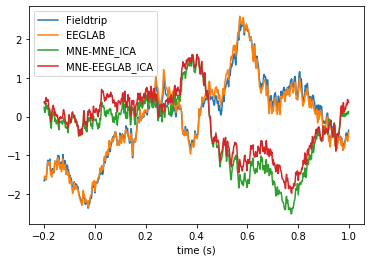

In [66]:
plt.figure()
plt.plot(epochs.times, fieldtrip_ts, label="Fieldtrip")
plt.plot(epochs.times, eeglab_ts, label="EEGLAB")
plt.plot(epochs.times, mne_ts*1e6, label="MNE-MNE_ICA")
plt.plot(epochs.times, mne_cleaned_ts*1e6, label="MNE-EEGLAB_ICA")
plt.legend()
plt.xlabel("time (s)")

In [63]:
print("Fieldtrip epoch data shape: ", tuple(fieldtrip_size.astype(int)))
print("EEGLAB epoch data shape: ", tuple(eeglab_size))
print("MNE (MNE ICA rejection) epoch data shape: ", mne_data.shape)
print("MNE (EEGLAB ICA rejection) epoch data shape: ", mne_cleaned_data.shape)

Fieldtrip epoch data shape:  (22, 107, 600)
EEGLAB epoch data shape:  (21, 107, 600)
MNE (MNE ICA rejection) epoch data shape:  (21, 107, 600)
MNE (EEGLAB ICA rejection) epoch data shape:  (23, 107, 600)
